In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

## Linear model

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 0,  6,  2, 10,  9,  8,  1,  4,  7]), tensor([5, 3]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-5.5657],
        [-8.8503]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.9953]], requires_grad=True),
 Parameter containing:
 tensor([-0.6985], requires_grad=True))

In [7]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938],
        [-1.6938]], grad_fn=<AddmmBackward>)

In [8]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [9]:
linear_model.parameters()

<generator object Module.parameters at 0x7ff57972fdd0>

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3221]], requires_grad=True),
 Parameter containing:
 tensor([0.7407], requires_grad=True)]

In [11]:
def training_loop(n_epochs, model, optimizer, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [12]:
training_loop(
    n_epochs = 3000,
    model=linear_model,
    optimizer=optimizer,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 92.7800, Validation loss 319.2568
Epoch 1000, Training loss 4.2654, Validation loss 9.7233
Epoch 2000, Training loss 3.2101, Validation loss 3.9319
Epoch 3000, Training loss 3.1603, Validation loss 3.0245

Parameter containing:
tensor([[5.0927]], requires_grad=True)
Parameter containing:
tensor([-15.9941], requires_grad=True)


In [13]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [14]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [15]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [16]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [18]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2193], requires_grad=True)

In [19]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs=5000,
    model=seq_model,
    optimizer=optimizer,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)
print('output', seq_model(t_un_val)) 
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 142.3715, Validation loss 440.9338
Epoch 1000, Training loss 4.6563, Validation loss 45.6771
Epoch 2000, Training loss 3.1341, Validation loss 23.4693
Epoch 3000, Training loss 2.6527, Validation loss 15.1466
Epoch 4000, Training loss 2.4238, Validation loss 10.6495
Epoch 5000, Training loss 2.3036, Validation loss 8.0295
output tensor([[ 7.6146],
        [24.0117]], grad_fn=<AddmmBackward>)
answer tensor([[ 8.],
        [28.]])
hidden tensor([[ 0.0152],
        [-0.0063],
        [ 0.0033],
        [ 0.0089],
        [-0.0706],
        [ 0.0065],
        [ 0.0175],
        [ 0.0013]])


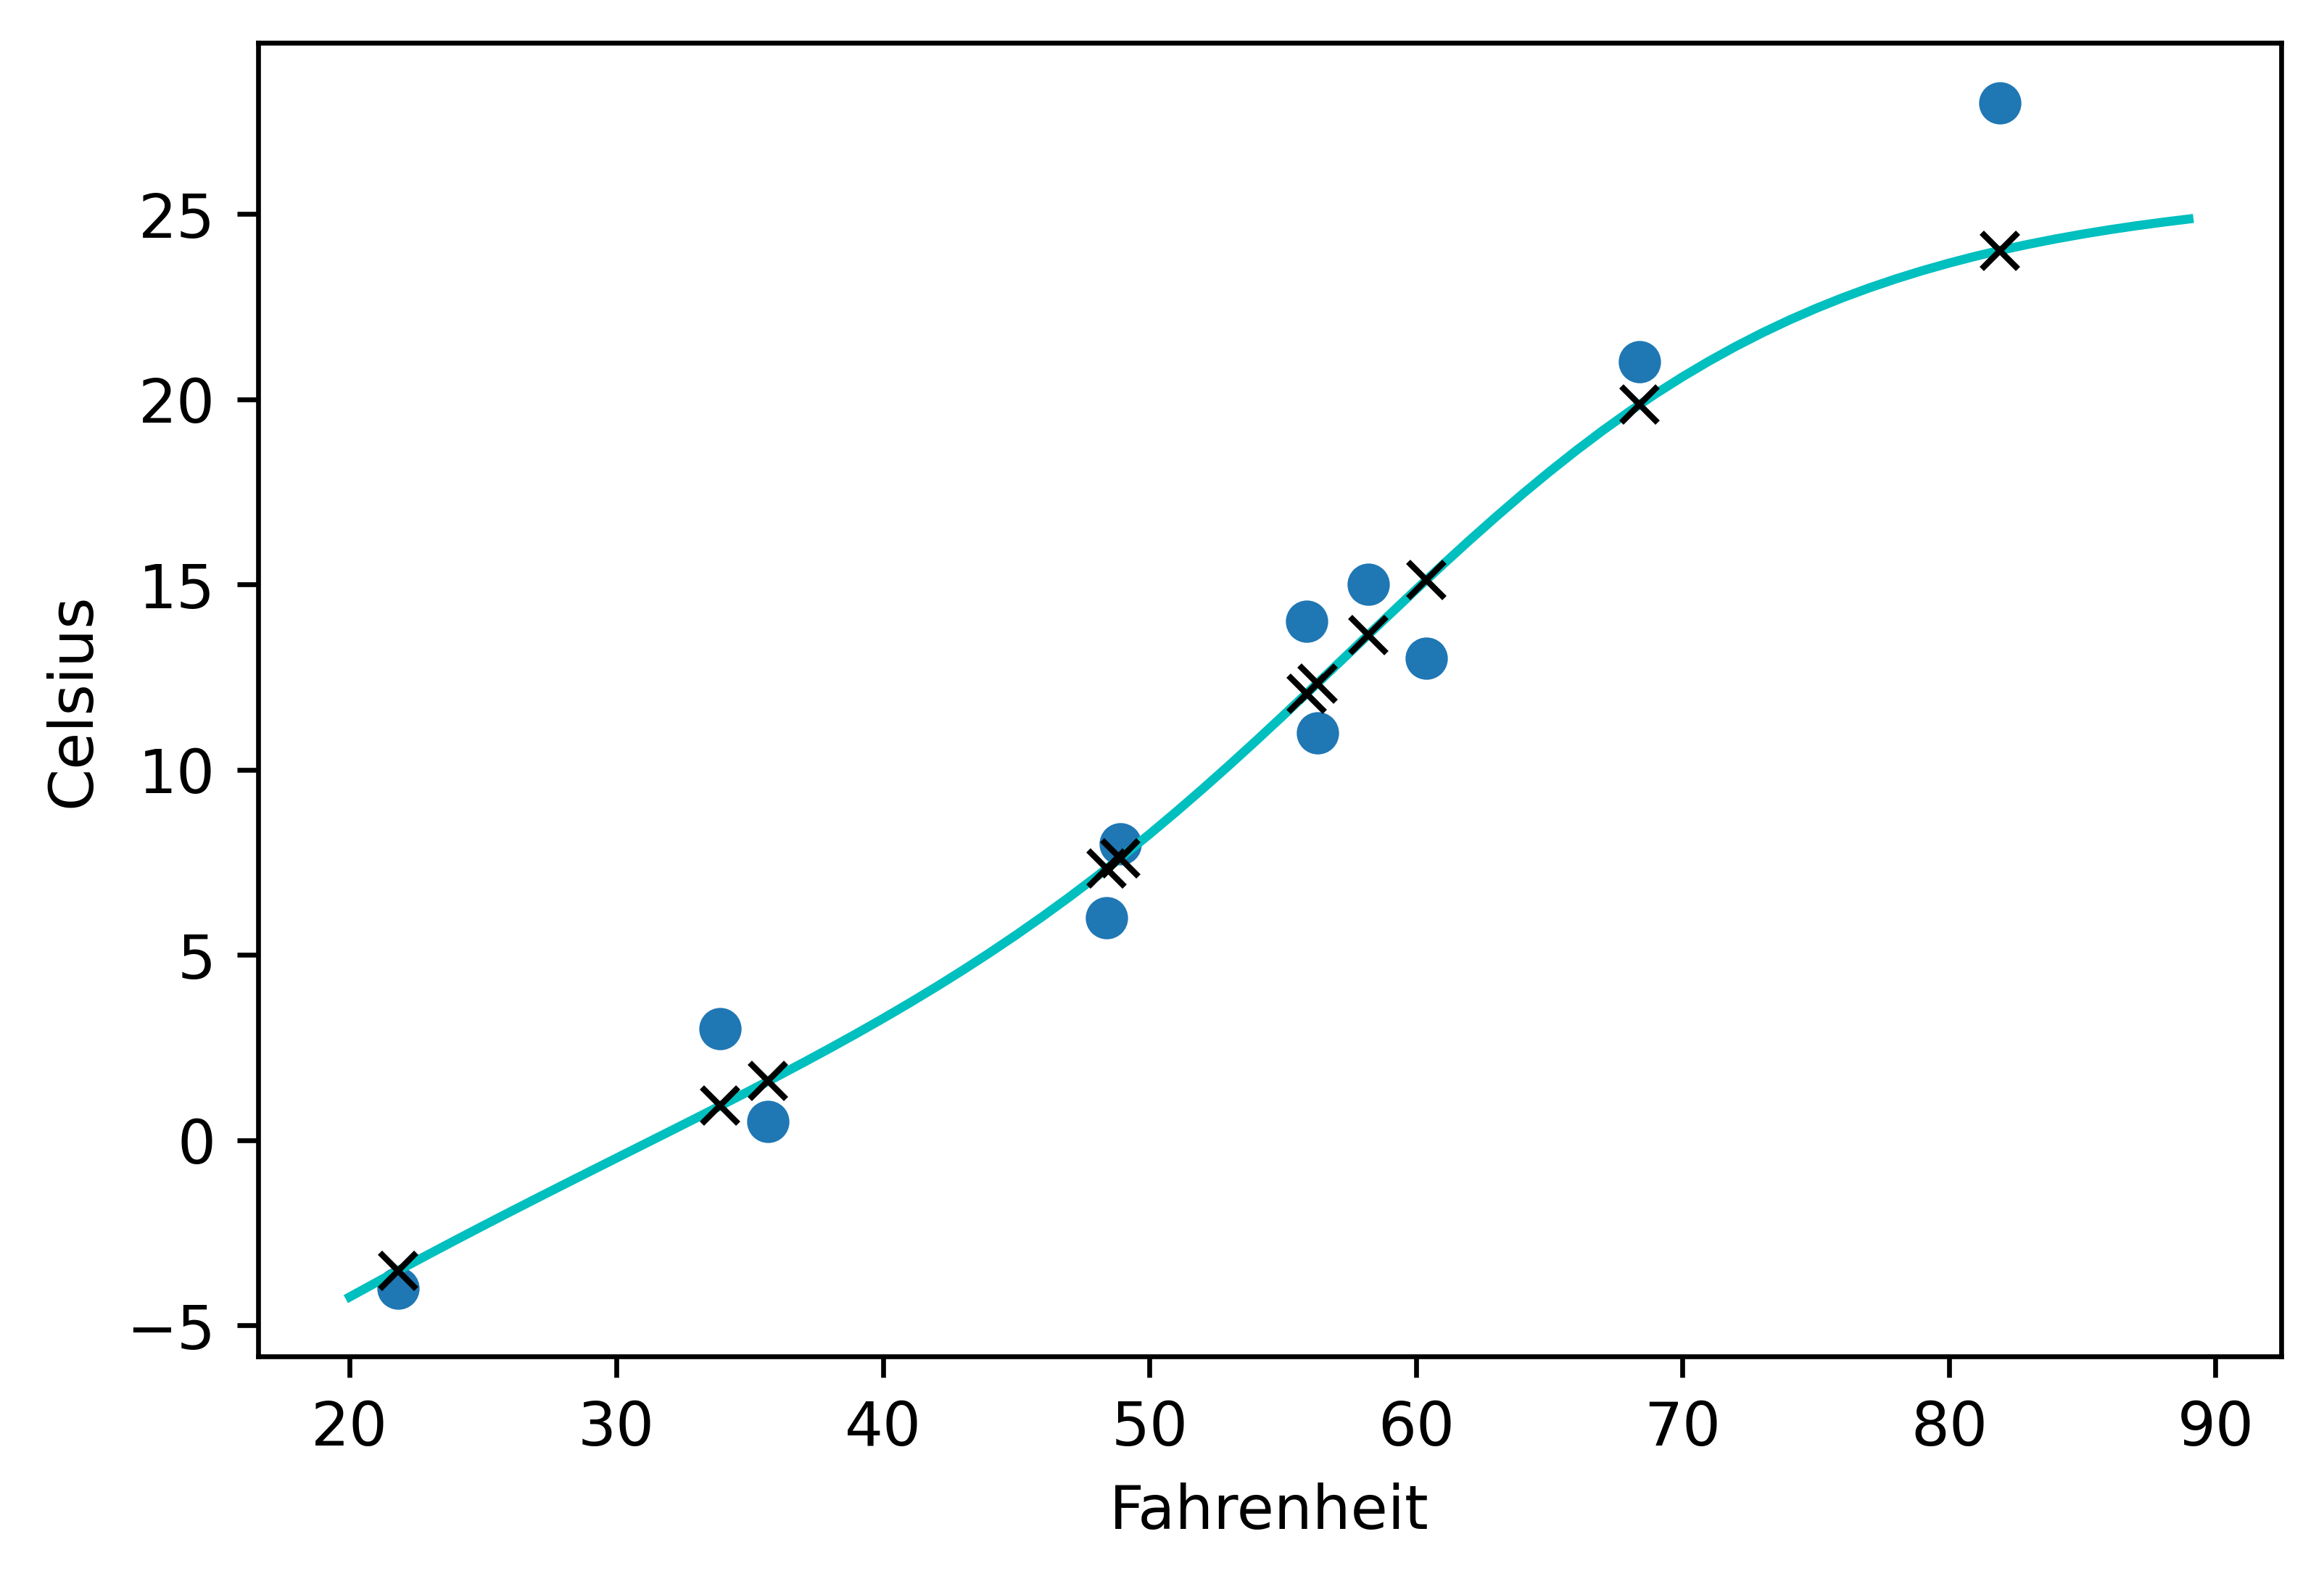

In [20]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

## Dataset and DataLoader

In [21]:
from torchvision import datasets
import matplotlib.pyplot as plt

In [22]:
data_path = '../data/03/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class_names = [
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
]

In [24]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [25]:
len(cifar10)

50000

In [26]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FF57531DBB0>,
 1,
 'automobile')

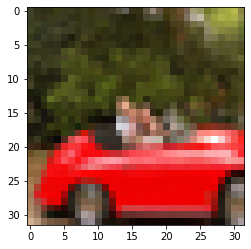

In [27]:
plt.imshow(img)
plt.show()

In [28]:
from torchvision import transforms

In [29]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [30]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [31]:
tensor_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=to_tensor
)

In [32]:
tensor_cifar10, tensor_cifar10[99]

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../data/03/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 (tensor([[[0.2431, 0.1961, 0.1804,  ..., 0.6549, 0.7176, 0.5373],
           [0.2471, 0.2157, 0.2039,  ..., 0.6392, 0.6706, 0.5686],
           [0.2275, 0.2510, 0.2196,  ..., 0.6000, 0.5882, 0.4824],
           ...,
           [0.6745, 0.5608, 0.5098,  ..., 0.3686, 0.5529, 0.5451],
           [0.7176, 0.5882, 0.3137,  ..., 0.3176, 0.5294, 0.5608],
           [0.8196, 0.7137, 0.5451,  ..., 0.2314, 0.5098, 0.6627]],
  
          [[0.2510, 0.1961, 0.1725,  ..., 0.6745, 0.7216, 0.5333],
           [0.2549, 0.2078, 0.1961,  ..., 0.6627, 0.6824, 0.5725],
           [0.2431, 0.2588, 0.2353,  ..., 0.6078, 0.6039, 0.5020],
           ...,
           [0.5294, 0.4314, 0.2196,  ..., 0.2941, 0.4235, 0.4118],
           [0.5725, 0.4627, 0.2510,  ..., 0.2824, 0.4627, 0.4902],
           [0.6824, 0.5922, 0.4275,  ..., 0.2118, 0.4667, 0.6118]],
  
         

In [33]:
img_t = tensor_cifar10[99][0]
img_t.shape, img_t.min(), img_t.max()

(torch.Size([3, 32, 32]), tensor(0.), tensor(1.))

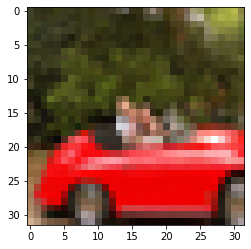

In [34]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [35]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [36]:
imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [37]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


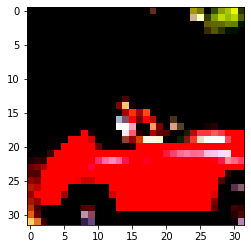

In [38]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [39]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [
    (img, label_map[label])
    for img, label in transformed_cifar10 if label in [0, 2]
]
cifar2_val = [
    (img, label_map[label])
    for img, label in transformed_cifar10 if label in [0, 2]
]

In [40]:
n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out,
    )
)

In [41]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([
    [1.0, 2.0, 3.0],
    [1.0, 2.0, 3.0]
])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [42]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


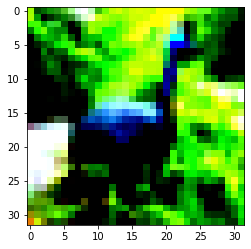

In [43]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [44]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[0.5260, 0.4740]], grad_fn=<SoftmaxBackward>)

In [45]:
_, index = torch.max(out, dim=1)
index

tensor([0])

In [46]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
loss = nn.NLLLoss()
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.7104, grad_fn=<NllLossBackward>)

In [47]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 1

In [48]:
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 2.687186


In [49]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print('Training on device {}.'.format(device))

Training on device cuda.


In [50]:
cifar2 = [(img.to('cuda'), torch.tensor(label, device=device)) for img, label in cifar2]
cifar2_val = [(img.to('cuda'), torch.tensor(label, device=device)) for img, label in cifar2_val]

In [51]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size=64, shuffle=True
)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch == 1 or epoch % 10 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.599630
Epoch: 1, Loss: 0.257595
Epoch: 10, Loss: 0.635023
Epoch: 20, Loss: 0.181675
Epoch: 30, Loss: 0.177565
Epoch: 40, Loss: 0.128136
Epoch: 50, Loss: 0.049105
Epoch: 60, Loss: 0.079528
Epoch: 70, Loss: 0.019304
Epoch: 80, Loss: 0.031189
Epoch: 90, Loss: 0.005146


In [52]:
val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size=64, shuffle=False
)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.9988


In [53]:
numel_list = [
    p.numel() for p in model.parameters() if p.requires_grad == True
]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

## Custom nn.Module

In [54]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [55]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [56]:
img, _ = cifar2[0]
img = img.cpu()
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

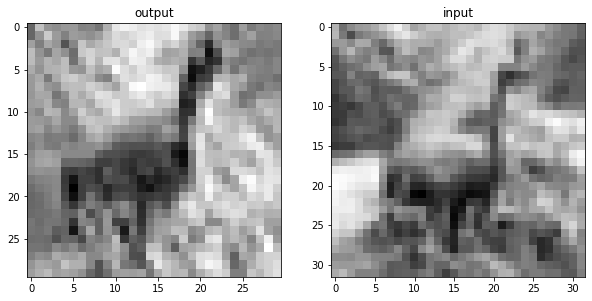

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [58]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

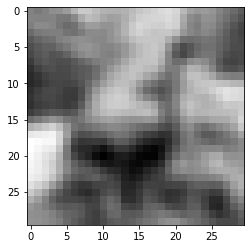

In [59]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [60]:
conv_v = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv_v.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv_v.bias.zero_()

conv_h = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv_h.weight[:] = torch.tensor([
        [-1.0, -1.0, -1.0],
        [0.0, 0.0, 0.0],
        [1.0, 1.0, 1.0]
    ])
    conv_h.bias.zero_()

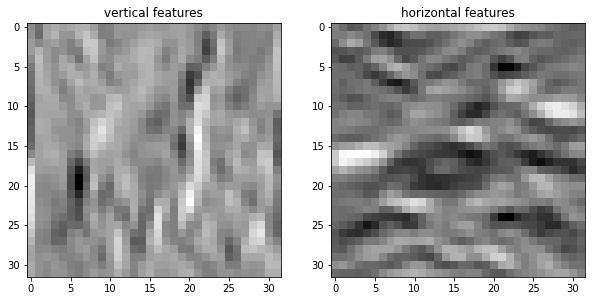

In [61]:
output_v = conv_v(img.unsqueeze(0))
output_h = conv_h(img.unsqueeze(0))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('vertical features')
plt.imshow(output_v[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(output_h[0, 0].detach(), cmap='gray')
plt.title('horizontal features')
plt.show()

In [62]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [63]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [64]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [65]:
model = ConvNet()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list, model(img.unsqueeze(0))

(18090,
 [432, 16, 1152, 8, 16384, 32, 64, 2],
 tensor([[-0.0551,  0.0194]], grad_fn=<AddmmBackward>))

In [66]:
from datetime import datetime

def training_loop(n_epochs, model, optimizer, loss_fn, train_loader, log_every=10):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % log_every == 0:
            print('[{}] Epoch {}, Training loss {}'.format(
               datetime.now(), epoch, loss_train / len(train_loader))
            )

In [67]:
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

[2021-02-18 11:56:17.946949] Epoch 1, Training loss 0.558322595942552
[2021-02-18 11:56:31.447543] Epoch 10, Training loss 0.3312612785275575
[2021-02-18 11:56:47.816321] Epoch 20, Training loss 0.2907870015141311
[2021-02-18 11:57:03.908561] Epoch 30, Training loss 0.26726609060339107
[2021-02-18 11:57:20.765586] Epoch 40, Training loss 0.2501804180395831
[2021-02-18 11:57:37.869909] Epoch 50, Training loss 0.23161716042620362
[2021-02-18 11:57:54.967954] Epoch 60, Training loss 0.21600473605713266
[2021-02-18 11:58:12.948437] Epoch 70, Training loss 0.1985352984184672
[2021-02-18 11:58:30.566857] Epoch 80, Training loss 0.18309167691856432
[2021-02-18 11:58:48.824873] Epoch 90, Training loss 0.16702151811046964
[2021-02-18 11:59:07.172546] Epoch 100, Training loss 0.15453902819448975


In [68]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.94


In [69]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')
loaded_model = ConvNet()
loaded_model.load_state_dict(
    torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device)
)

<All keys matched successfully>

In [70]:
loaded_model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

## Model Design

In [71]:
class NetWidth(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            n_channels1, n_channels1 // 2,
            kernel_size=3, padding=1
        )
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [72]:
model = NetWidth(32)
sum(p.numel() for p in model.parameters())

38386

In [75]:
class NetDropout(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(
            n_channels1, n_channels1 // 2,
            kernel_size=3, padding=1
        )
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [76]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_channels1)
        self.conv2 = nn.Conv2d(
            n_channels1, n_channels1 // 2,
            kernel_size=3, padding=1
        )
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_channels1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [77]:
class NetRes(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            n_channels1, n_channels1 // 2,
            kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            n_channels1 // 2, n_channels1 // 2,
            kernel_size=3, padding=1
        )
        self.fc1 = nn.Linear(4 * 4 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv2(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [78]:
model = NetRes(32)
sum(p.numel() for p in model.parameters())

16130

In [79]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_channels, n_channels,
            kernel_size=3, padding=1, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(num_features=n_channels)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.constant_(self.batch_norm.weight, 0.5)
        nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out

In [89]:
class NetResDeep(nn.Module):
    def __init__(self, n_channels=32, n_blocks=10):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_channels=n_channels)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_channels, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_channels)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [90]:
model = NetResDeep(n_channels=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
)
validate(model, train_loader, val_loader)

[2021-02-18 12:39:06.406715] Epoch 1, Training loss 0.6624376853560187
[2021-02-18 12:41:07.390518] Epoch 10, Training loss 0.3073882985456734
[2021-02-18 12:43:21.702791] Epoch 20, Training loss 0.2429596213683201
[2021-02-18 12:45:35.915924] Epoch 30, Training loss 0.19265362962036375
[2021-02-18 12:47:50.249908] Epoch 40, Training loss 0.1465686050712303
[2021-02-18 12:50:04.556705] Epoch 50, Training loss 0.10229280728633237
[2021-02-18 12:52:18.944842] Epoch 60, Training loss 0.07455544968604282
[2021-02-18 12:54:33.326668] Epoch 70, Training loss 0.053866298691292475
[2021-02-18 12:56:47.724986] Epoch 80, Training loss 0.04026462203840826
[2021-02-18 12:59:02.120154] Epoch 90, Training loss 0.03765036366512157
[2021-02-18 13:01:16.547092] Epoch 100, Training loss 0.024353136704451623
Accuracy train: 0.98
Accuracy val: 0.98
